In [12]:
# import sys
# print (sys.version)

# Import libraries for Finance (Yahoo Finance) and Technical Analysis
import yfinance as yf
import talib

# Import libraries for data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Import internal functions to load data, etc
#import initialize

#Setting up constants
QUICK_EMA_PERIOD = 14
SLOW_EMA_PERIOD = 26

In [13]:
def init(numberOfStocks = 10, daysSince=14, typeDate='Close'):
    print(f"Requested days: {daysSince}.\nRequested stocks: {numberOfStocks}.\nData type: {typeDate}.")

    tickers_df = pd.read_csv('sp500_tickers.csv').head(numberOfStocks)
    tickers_df.set_index('Ticker', inplace=True)
    tickers_df.sort_values(by='Ticker', inplace=True)

    tickers_string = ' '.join(tickers_df.index.values)
    ts_today = pd.to_datetime('today')
    ts_origin = ts_today - pd.Timedelta(days=daysSince)

    return (yf.download(tickers_string, start=ts_origin, end=ts_today)[typeDate])
    
rawdata = init(numberOfStocks=50, daysSince=60)
rawdata.to_csv('./rawdata.csv')
    

Requested days: 60.
Requested stocks: 50.
Data type: Close.
[*********************100%***********************]  50 of 50 completed


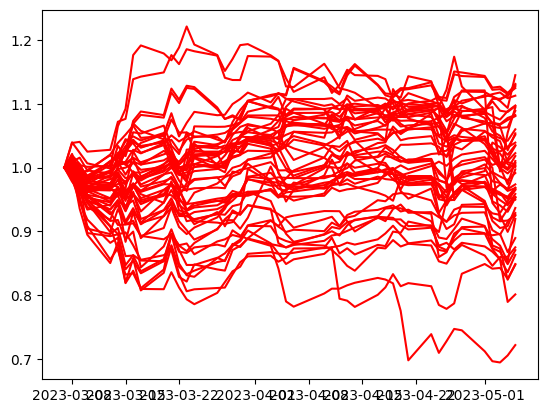

In [14]:
#Normalize the data to the first day.
#rawdata = rawdata / (rawdata.mean(axis=0))
rawdata = rawdata / rawdata.iloc[0]

for x in rawdata.columns:

    plt.plot(rawdata.index, rawdata[x], 'r')

plt.show()

In [17]:
def real2double(real_data):
    return(np.array(real_data,dtype='f8'))

In [20]:
def calcEMAs(qema_period, sema_period):
    '''Builds a multiindex dataframe composed of two sub-dfs: quick and slow EMA'''
    qEMA = pd.DataFrame()
    sEMA = pd.DataFrame()
    diffEMA = pd.DataFrame()
    for x in rawdata.columns:
        qEMA[x] = talib.EMA(real2double(rawdata[x].values), timeperiod=qema_period)
        sEMA[x] = talib.EMA(real2double(rawdata[x].values), timeperiod=sema_period)
        diffEMA[x] = 100*(qEMA[x] - sEMA[x])/qEMA[x]

    return(pd.concat([qEMA, sEMA, diffEMA], axis=1, keys=['Quick', 'Slow', 'Ratio']))


In [18]:
import pandas as pd 

def calcEMAs_test(qema_period, sema_period):
    '''Builds a multiindex dataframe composed of two sub-dfs: quick and slow EMA'''
    df_dict = dict((label, pd.DataFrame()) for label in ['Quick', 'Slow', 'Ratio'])

    for x in rawdata.columns:
        df_dict['Quick'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=qema_period)
        df_dict['Slow'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=sema_period)
        df_dict['Ratio'][x] = 100*(df_dict['Quick'][x] - df_dict['Slow'][x])/df_dict['Quick'][x]

    return(pd.concat([df_dict['Quick'], df_dict['Slow'], df_dict['Ratio']], axis=1, keys=['Quick', 'Slow', 'Ratio']))

In [19]:
EMA_df_test = calcEMAs_test(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD)

In [21]:
def compare_quick_slow_emas(EMA_df, difference):
    '''Returns a df of booleans depending on a percent comparison criterion
    For example, difference of 0.5 means that for a given day, qEMA was 0.5% higher than sEMA.'''
    return (EMA_df['Ratio'] > difference)


EMA_df = calcEMAs(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD)
test_positives = compare_quick_slow_emas(EMA_df, 0.5)

In [30]:
EMA_ratio_df_archive = 100*(EMA_df['Quick'] - EMA_df['Slow'])/EMA_df['Quick']
test_positives_archive = (EMA_ratio_df_archive > 0)

In [ ]:
def days_since_qema_trails(x, advantage):
    '''For each company, find out when EMA_14 fell below EMA_26 for the last time.
    This is done reverting the (EMA_14 - EMA_26) > 0 array and finding the last FALSE value.'''
    testPosSummary = dict()
    for company in x.columns:
        test_list =(list(test_positives[company]))
        test_list.reverse()
        testPosSummary[company] = test_list.index(False)
    return (testPosSummary)

    
testPosSummary = how_many_days_since_EMA14_outweighs_EMA26(emadif)
testPosSummary_df = pd.DataFrame(testPosSummary, index = [0]).transpose().sort_values(by=0, ascending=False)

Company AFL, with 19 periods


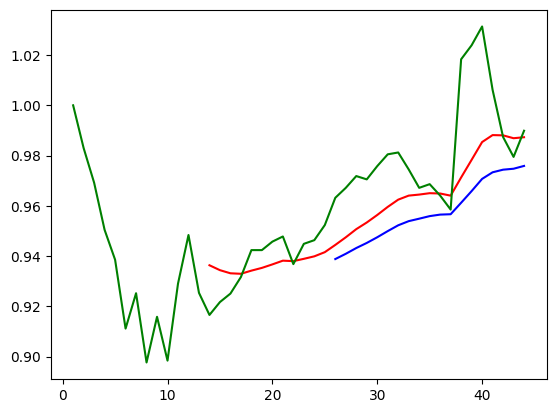

Company GOOG, with 19 periods


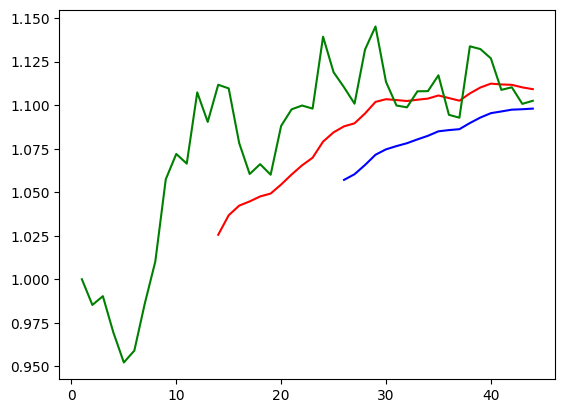

Company AON, with 19 periods


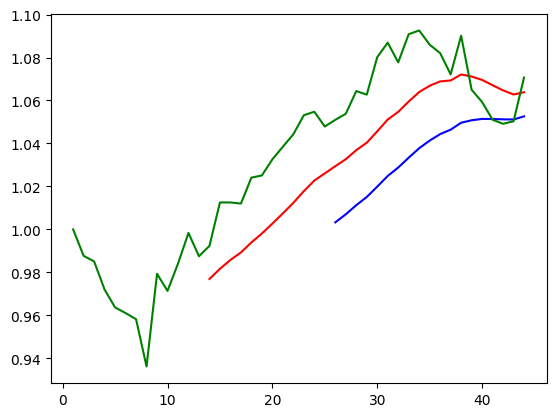

Company APD, with 19 periods


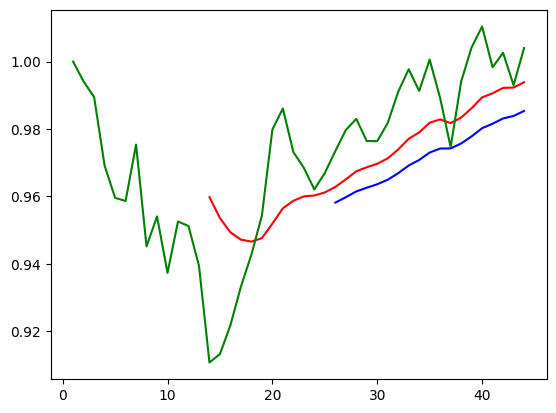

Company ALL, with 19 periods


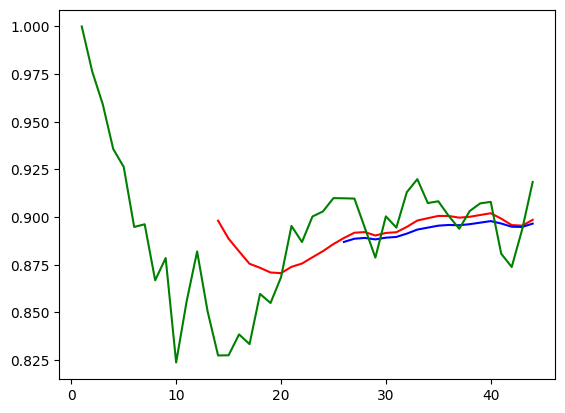

Company AKAM, with 19 periods


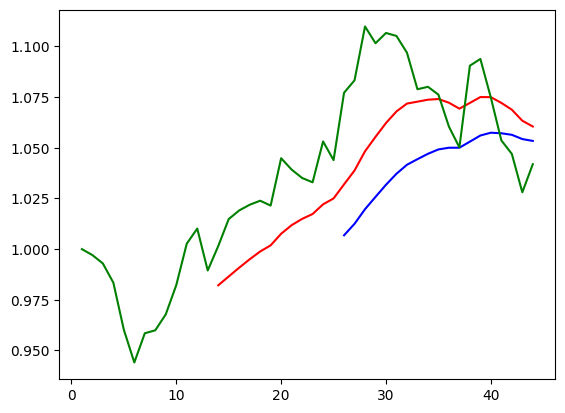

Company AJG, with 19 periods


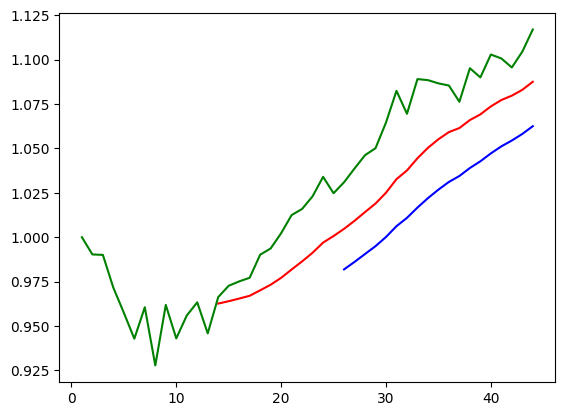

Company AWK, with 19 periods


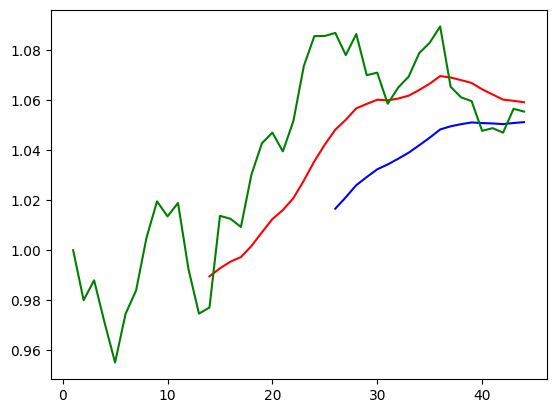

Company AEP, with 19 periods


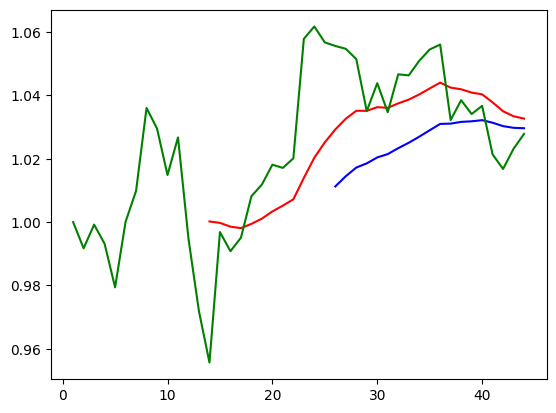

Company AEE, with 19 periods


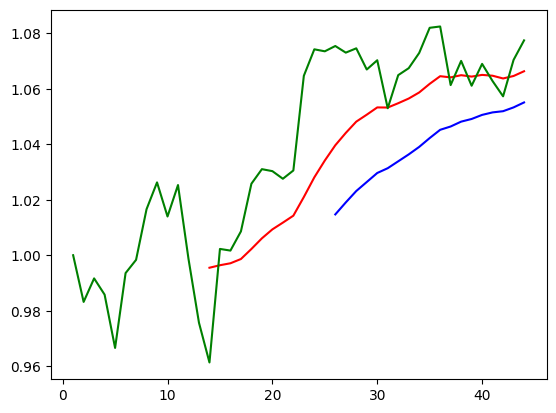

Company AMZN, with 19 periods


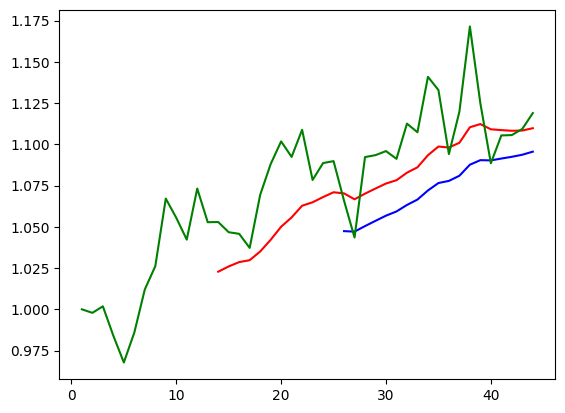

Company GOOGL, with 19 periods


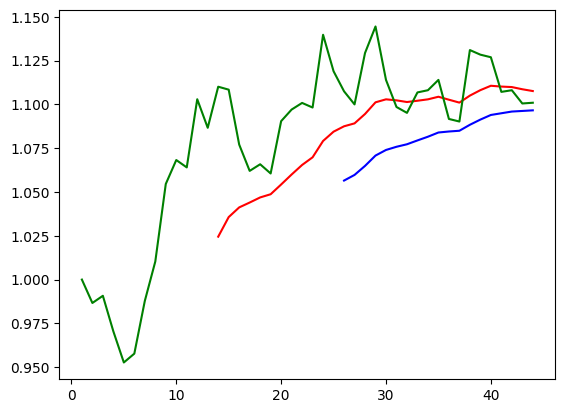

Company AAPL, with 19 periods


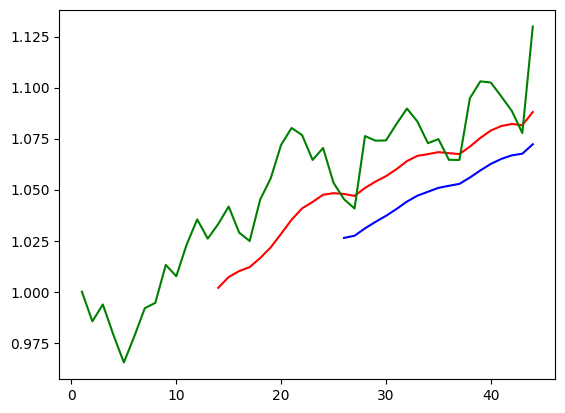

Company LNT, with 19 periods


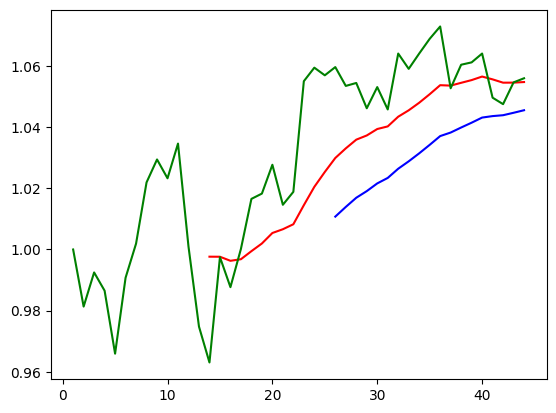

Company ACN, with 19 periods


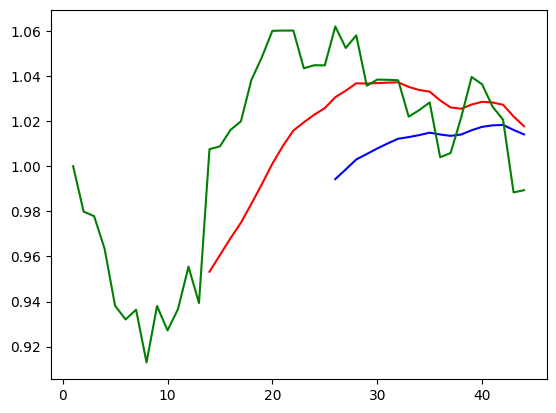

Company ACGL, with 19 periods


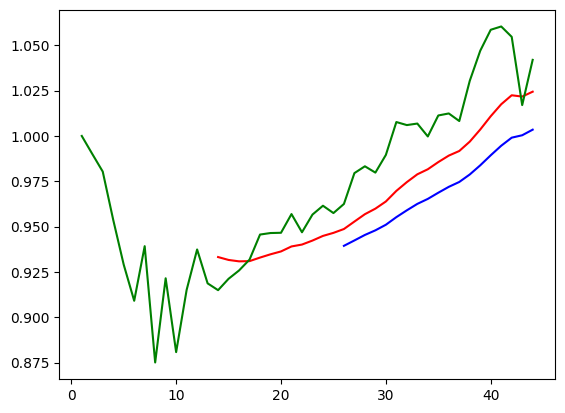

Company ABT, with 19 periods


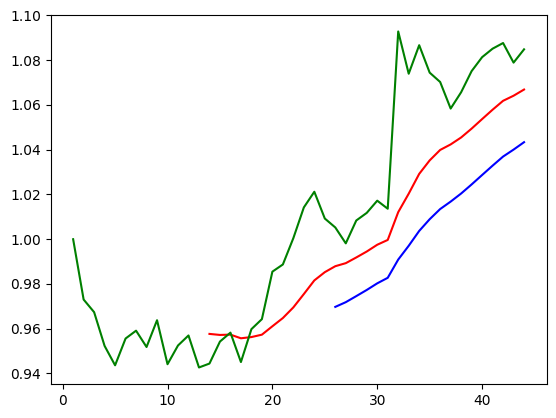

Company ABC, with 19 periods


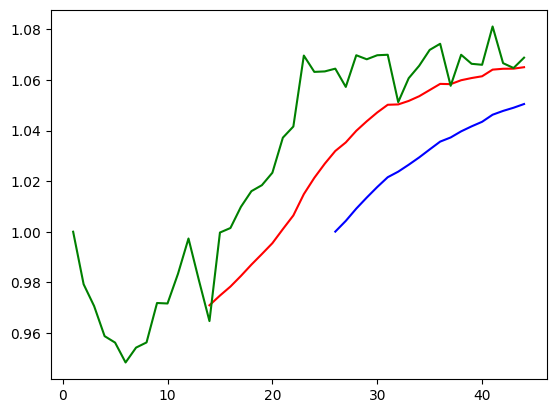

Company AAP, with 15 periods


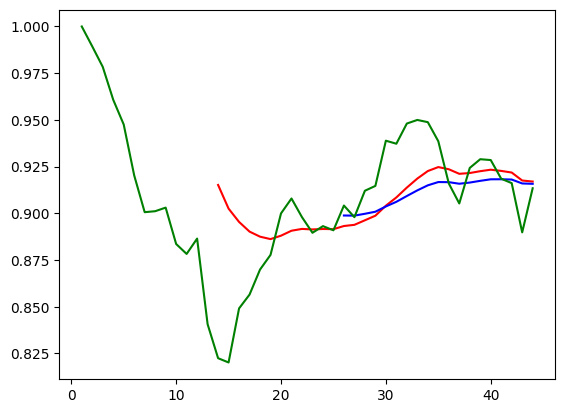

Company AIG, with 14 periods


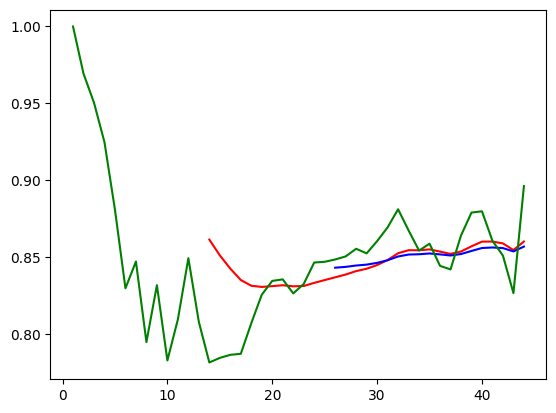

Company AOS, with 13 periods


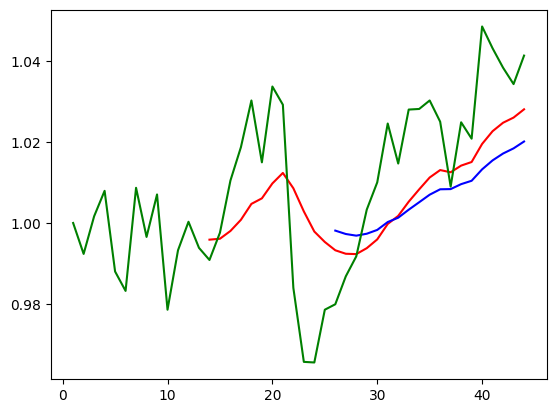

Company ALK, with 13 periods


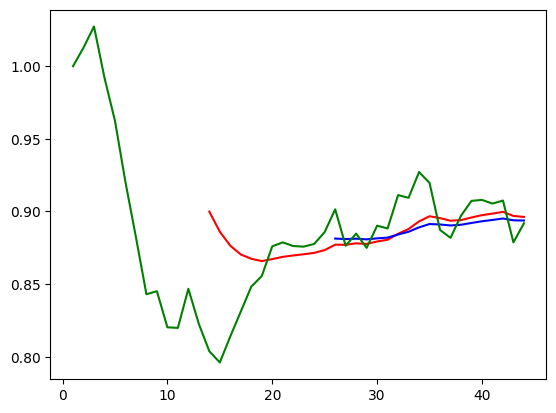

Company MO, with 10 periods


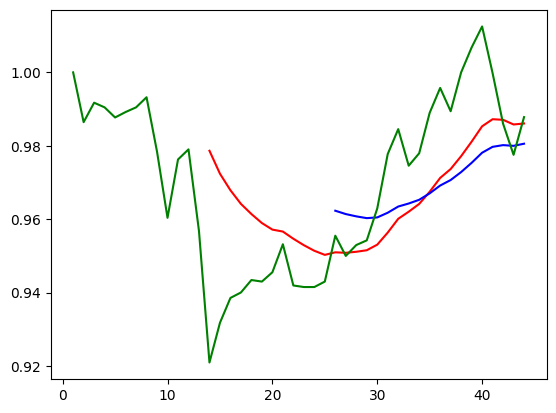

Company ALLE, with 6 periods


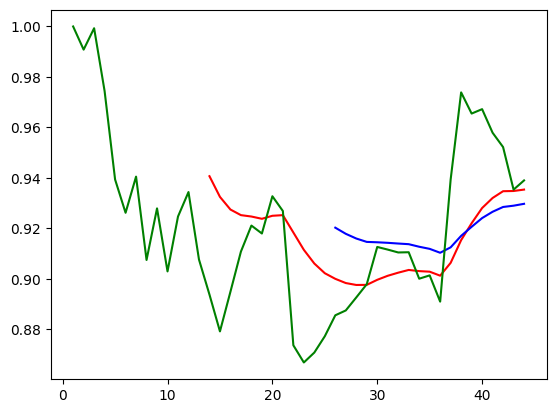

Company AME, with 4 periods


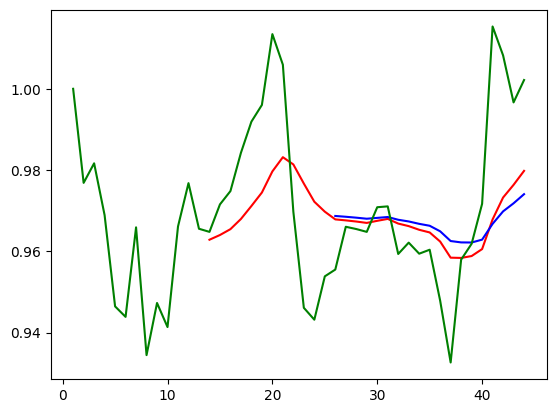

Company AXP, with 0 periods
Company MMM, with 0 periods
Company APTV, with 0 periods
Company APH, with 0 periods
Company ARE, with 0 periods
Company APA, with 0 periods
Company ATVI, with 0 periods
Company ANSS, with 0 periods
Company A, with 0 periods
Company ANET, with 0 periods
Company AMT, with 0 periods
Company AMP, with 0 periods
Company AMGN, with 0 periods
Company AMD, with 0 periods
Company AMCR, with 0 periods
Company AAL, with 0 periods
Company ALGN, with 0 periods
Company ALB, with 0 periods
Company AES, with 0 periods
Company ADP, with 0 periods
Company ADM, with 0 periods
Company ADI, with 0 periods
Company ADBE, with 0 periods
Company ABBV, with 0 periods
Company AMAT, with 0 periods


In [ ]:
x_axis = np.linspace(1,rawdata.shape[0],rawdata.shape[0])

for x in numpos_df.index:
    print(f"Company {x}, with {numpos_df.loc[x][0]} periods")
    if (numpos_df.loc[x][0] >= 4):
        plt.plot(x_axis, EMA_14[x], 'r')
        plt.plot(x_axis, EMA_26[x], 'b')
        plt.plot(x_axis, rawdata[x], 'g')
        plt.show()

In [ ]:
a = [1, 2, 3]
b = [4, 5, 6]
test = pd.DataFrame({'colA': a, 'colB': b})

test



,colA,colB
0,1,4
1,2,5
2,3,6


In [ ]:
medias = test.mean()
medias

colA    2.0
colB    5.0
dtype: float64

In [ ]:
normalized = test / medias
normalized

,colA,colB
0,0.5,0.8
1,1.0,1.0
2,1.5,1.2


In [ ]:
numpos_df.index

Index(['AFL', 'GOOG', 'AON', 'APD', 'ALL', 'AKAM', 'AJG', 'AWK', 'AEP', 'AEE',
       'AMZN', 'GOOGL', 'AAPL', 'LNT', 'ACN', 'ACGL', 'ABT', 'ABC', 'AAP',
       'AIG', 'AOS', 'ALK', 'MO', 'ALLE', 'AME', 'AXP', 'MMM', 'APTV', 'APH',
       'ARE', 'APA', 'ATVI', 'ANSS', 'A', 'ANET', 'AMT', 'AMP', 'AMGN', 'AMD',
       'AMCR', 'AAL', 'ALGN', 'ALB', 'AES', 'ADP', 'ADM', 'ADI', 'ADBE',
       'ABBV', 'AMAT'],
      dtype='object')

NameError: name 'y' is not defined

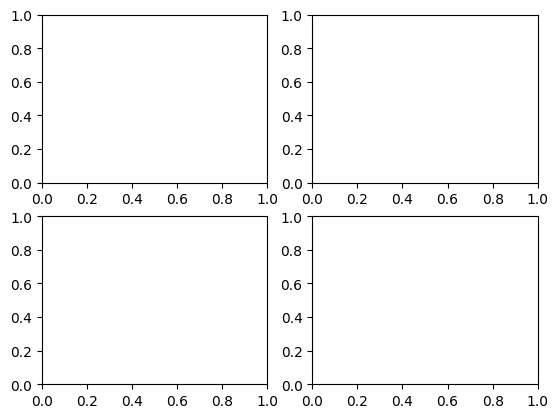

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()



In [ ]:
(numpos_df > 5).value_counts()

True     311
False    190
Name: count, dtype: int64